# Developing an AI application

## Course Project: Image classification with a pretrained convolutional neural network in PyTorch

Author: Christoph Schauer <br>
Date: 11 December 2018

## Preface

This notebook is a lightly edited version of the first part of my course project of the Deep Learning module of Udacity's [Data Scientist Nanodegree](https://eu.udacity.com/course/data-scientist-nanodegree--nd025).

In this project, a pre-trained convolutional neural network is used and the few last layers are trained on images of flowers -  [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) - to develop an application that can determine the species of a flower in an image. This notebook is the first part of this project. 

The second part is converting this code into Python scripts for training and predicting the species of flowers that can be run from the command line, taking a number of arguments such as which pre-trained model to use, which hyperparameters to use for training, whether to use the GPU, etc. These scripts are train.py and predict.py.

The instructions and descriptions in this notebook are lightly edited for clarity.

## Table of Contents

The project is broken down into multiple steps:

* 1. Introduction
* 2. Load and preprocess the image data
* 3. Building and training the classifier
* 4. Test network
* 5. Save and load a checkpoint
* 6. Build a predictor

## 1. Introduction

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [1]:
# Imports here

import numpy as np
import json
from collections import OrderedDict
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load and preprocess the image data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Define directories

data_dir = "flowers"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"

In [3]:
# Define transforms for training, validation, and testing sets

train_transforms = transforms.Compose([transforms.RandomRotation(25),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder

train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + "/valid", transform = valid_transforms)
test_data = datasets.ImageFolder(data_dir + "/test", transform = test_transforms)

class_names = train_data.classes

# Using the image datasets and the trainforms, define the dataloaders
    
batch_size = 32

trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [12]:
# Check data

print("Number of classes:", len(class_names))
print("Class names:", class_names)
print("Training data:", train_data)
print("Validation data:", valid_data)
print("Testing data:", test_data)

Number of classes: 102
Class names: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Training data: Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flowers/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-25, 25), resample=False, expand=False)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BI

In [13]:
# Store number of observations in training, validation, and test data

train_obs = 6552
valid_obs = 818
test_obs = 819

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [14]:
with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

In [18]:
# Check data
print("Number of classes:", len(cat_to_name))
keys = ("1", "2", "3", "4", "5")
print("First 5 flower species:", {k: cat_to_name[k] for k in keys})

Number of classes: 102
First 5 flower species: {'1': 'pink primrose', '2': 'hard-leaved pocket orchid', '3': 'canterbury bells', '4': 'sweet pea', '5': 'english marigold'}


# 3. Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [29]:
# Build and train your network

# I use the pre-trained VGG16 model from torchvision.models as my default model:
print(models.vgg16(pretrained = True))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [30]:
# Load the model
model = models.vgg16(pretrained = True)

# Freeze model parameters to prevent backpropagation in the pre-trained network
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier of the pre-trained model with a new one which will be trained on the flowers data:
input_layer = model.classifier[0].in_features
hidden_layer = 2048
output_layer = len(cat_to_name)

classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(input_layer, hidden_layer)),
    ("relu1", nn.ReLU()),
    ("dropout", nn.Dropout(p = 0.25)),
    ("fc2", nn.Linear(hidden_layer, output_layer)),
    ("output", nn.LogSoftmax(dim = 1))
    ]))

model.classifier = classifier

# Send the model to GPU if available
if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
    print("Training model on GPU")
else:
    device = torch.device("cpu")
    print("Training model on CPU")

model = model.to(device)

# Set hyperparameters
epochs = 10
learning_rate = 0.001
batches = len(trainloader.batch_sampler)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate) # Adam optimizer

print(f"Training model in {epochs} epochs")
print(f"Training model on {train_obs} images in {batches} batches of batch size {batch_size}")

Training model on GPU
Training model in 10 epochs
Training model on 6552 images in 205 batches of batch size 32


Note: I'm training the model on my own computer, as I happen to have a Nvidia GPU and can use CUDA.

In [31]:
# start training

start_time = time.time() 

# reset model
model.zero_grad()

for e in range(epochs):
    
    print(f"Starting training for epoch {e+1} of {epochs}")

    total = 0
    correct = 0
    running_loss = 0
    
    #set training mode
    model.train()

    for ii, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()     
        
        # forward and backward passes
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # running loss of epoch
        running_loss += loss.item()
    
        # accuracy of epoch
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
           
    # print after each epoch
    print(f"Epoch {e+1} of {epochs}", 
          " --- Training loss:{:.4f}".format(running_loss/batches), 
          " --- Training accuracy:{:.4f}".format(correct/total))

    # evaluate model in validation set
    
    # reset metrics for epoch
    valid_correct = 0
    valid_total = 0
    valid_running_loss = 0

    # don't calculate gradients
    model.eval()
    with torch.no_grad():
        for ii, (images, labels) in enumerate(validloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
         
            # accuracy of epoch
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
            
        # print after each epoch
        print(f"Epoch {e+1} of {epochs}", 
              "--- Validation loss:{:.4f}".format(valid_running_loss/batches), 
              "--- Validation accuracy:{:.4f}".format(valid_correct/valid_total))
                
end_time = time.time()
duration = (end_time - start_time)//60
print("Training complete")
print(f"Training time: {duration} minutes")

Starting training for epoch 1 of 10
Epoch 1 of 10  --- Training loss:2.4601  --- Training accuracy:0.4547
Epoch 1 of 10 --- Validation loss:0.1041 --- Validation accuracy:0.7738
Starting training for epoch 2 of 10
Epoch 2 of 10  --- Training loss:1.2740  --- Training accuracy:0.6561
Epoch 2 of 10 --- Validation loss:0.0691 --- Validation accuracy:0.8484
Starting training for epoch 3 of 10
Epoch 3 of 10  --- Training loss:1.1070  --- Training accuracy:0.7039
Epoch 3 of 10 --- Validation loss:0.0738 --- Validation accuracy:0.8582
Starting training for epoch 4 of 10
Epoch 4 of 10  --- Training loss:1.0197  --- Training accuracy:0.7263
Epoch 4 of 10 --- Validation loss:0.0689 --- Validation accuracy:0.8643
Starting training for epoch 5 of 10
Epoch 5 of 10  --- Training loss:0.9392  --- Training accuracy:0.7497
Epoch 5 of 10 --- Validation loss:0.0668 --- Validation accuracy:0.8594
Starting training for epoch 6 of 10
Epoch 6 of 10  --- Training loss:0.9475  --- Training accuracy:0.7544
Epoc

## 4. Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [32]:
# Validation on the test set

test_correct = 0
test_total = 0

model.eval()
with torch.no_grad():
    for ii, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print("Classification accuracy on test set:{:.4f}".format(test_correct/test_total))

Classification accuracy on test set:0.8584


## 5. Save and load the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [38]:
# Save the checkpoint 

model.class_to_idx = train_data.class_to_idx

model_state = {
    "epoch": epochs,
    "state_dict": model.state_dict(),
    "optimizer_dict": optimizer.state_dict(),
    "classifier": classifier,
    "class_to_idx": model.class_to_idx,
}

torch.save(model_state, "checkpoint.pth")
print("Saving complete")

Saving complete


At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [39]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath = "checkpoint.pth"):
    
    # Send model to CPU for inference later because matplotlib doesn't work with GPU
    device = torch.device("cpu")
    model_state = torch.load(filepath, map_location = device)
    
    model = models.vgg16(pretrained = True)
    model.classifier = model_state["classifier"]
    model.load_state_dict(model_state["state_dict"])
    model.class_to_idx = model_state["class_to_idx"]
   
    model = model.to("cpu")

    return model

model_rebuilt = load_checkpoint(filepath = "checkpoint.pth")
print("Loading complete")

Loading complete


# 6. Build a predictor function

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [41]:
# Process a PIL image for use in a PyTorch model

def process_image(image): 
          
    image = Image.open(image).convert("RGB")
    image_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])
    image = image_transforms(image)
    return image

In [42]:
# Function to convert a PyTorch tensor back to the (cropped) original image to check if the transform works

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

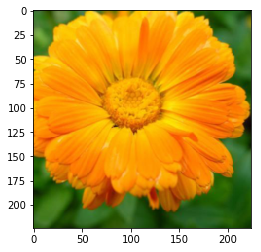

In [44]:
# load and show a sample image from a directory

directory = test_dir
folder = "5"
filename = "image_05186.jpg"

sample_image = process_image(f"{directory}/{folder}/{filename}")

# show the image
imshow(sample_image.numpy());

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

In [45]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk = 5):
    
    # set evaluation mode
    model.eval()
    
    # set CPU mode - no need for GPU here
    model = model.cpu()
    
    # load and process image with the function defined above
    image = process_image(image_path).unsqueeze(0)
    
    # calculate probabilities for most likely classes
    with torch.no_grad():
        output = model.forward(image)
        top_probs, top_labels = torch.topk(output, topk)
        top_probs = top_probs.exp()
        
    class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
    top_classes = list()
    
    for label in top_labels.numpy()[0]:
        top_classes.append(class_to_idx_inv[label])
        
    return top_probs.numpy()[0], top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

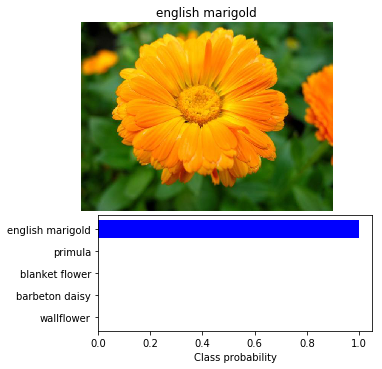

In [47]:
# Display an image along with the top 5 classes

# enter directory (training, validation, testing), folder (class), and filename of the image
directory = test_dir
folder = "5"
filename = "image_05186.jpg"

sample_image_file = f"{directory}/{folder}/{filename}"
correct_class = cat_to_name[folder]
top_probs, top_classes = predict(sample_image_file, model_rebuilt)
label = top_classes[0]

fig = plt.figure(figsize = (10, 7))
img = plt.subplot2grid((16, 10), (0, 0), colspan = 8, rowspan = 8) # ändern
bars = plt.subplot2grid((16, 10), (8, 2), colspan = 5, rowspan = 5) # ändern

image = Image.open(sample_image_file)
img.axis("off")
img.set_title(f"{cat_to_name[label]}")
img.imshow(image)

labels = []
for class_idx in top_classes:
    labels.append(cat_to_name[class_idx])

yticks = [0,1,2,3,4]

bars.set_yticks(yticks)
bars.set_yticklabels(labels)
bars.set_xlabel("Class probability")
bars.invert_yaxis()
bars.barh(yticks, top_probs, color = "blue")

plt.show()